# **Fine-tuning Wav2Vec2 for English ASR with 🤗 Transformers**


*   Authors: Romain Mussard, Salma OUARDI



### Model Definition

Wav2Vec2 is a pretrained model for Automatic Speech Recognition (ASR) and was released in [September 2020](https://ai.facebook.com/blog/wav2vec-20-learning-the-structure-of-speech-from-raw-audio/) by Alexei Baevski, Michael Auli, and Alex Conneau.

Using a novel contrastive pretraining objective, Wav2Vec2 learns powerful speech representations from more than 50.000 hours of unlabeled speech. Similar, to [BERT's masked language modeling](http://jalammar.github.io/illustrated-bert/), the model learns contextualized speech representations by randomly masking feature vectors before passing them to a transformer network.

![wav2vec2_structure](https://raw.githubusercontent.com/patrickvonplaten/scientific_images/master/wav2vec2.png)

For the first time, it has been shown that pretraining, followed by fine-tuning on very little labeled speech data achieves competitive results to state-of-the-art ASR systems. Using as little as 10 minutes of labeled data, Wav2Vec2 yields a word error rate (WER) of less than 5% on the clean test set of [LibriSpeech](https://huggingface.co/datasets/librispeech_asr) - *cf.* with Table 9 of the [paper](https://arxiv.org/pdf/2006.11477.pdf).

In this notebook, we will give an in-detail explanation of how Wav2Vec2's pretrained checkpoints can be fine-tuned on any speech dataset. 

We will compare how well Wev2Vec is doing on 2 different languages, Spanish and Finnish. The goal is to develop a model that will allow to do do good ASR on low resource languages. We focused on studying if an English pretrained model will better or not than a multilingual pretrained model for Finnish and Spanish ASR.

1.   We start by connecting to the hugging-face hub to be able to save our checkpoints.
2.   We mount our drive to save the trainer's logs.
3.   We setup Kaggle's API.
4.   We load and preprocess our data [CSS10](https://github.com/kyubyong/css10): A Collection of Single Speaker Speech Datasets for 10 Languages.
5.   We configure our Tokenizer (Wav2Vec2CTCTokenizer) and Feature Extractor (Wav2Vec2FeatureExtractor) that are provided with the the Wav2Vec2 model.
6.   We fine-tune our model and train it After that, we will correctly evaluate it on the test data with the word error rate (WER) metric and verify that it has indeed learned to correctly transcribe speech.  
7.   Finally we save our model and processor (tokenizer + feature extractor) in the hugging-face hub and the logs in our mounted drive.


### First Setup

Before we start, let's install both `datasets` and `transformers` from master. Also, we need the `librosa` package to load audio files and the `jiwer` to evaluate our fine-tuned model using the [word error rate (WER)](https://huggingface.co/metrics/wer) metric ${}^1$.

In [ ]:
%%capture
!pip install datasets==2.7.1
!pip install -U transformers==4.24.0  # 4.17.0
!pip install jiwer


Then we need to install Git-LFS to upload our model checkpoints:

In [ ]:
%%capture
!apt install git-lfs

In [ ]:
%%capture
!pip install evaluate

In [ ]:
%%capture
!pip install unidecode

We import the necessary libraries

In [ ]:
import json
import random
import re
from pathlib import Path

import datasets
from datasets import Dataset, DatasetDict

import zipfile

from unidecode import unidecode

import numpy as np
import matplotlib.pyplot as plt
import evaluate
import IPython.display as ipd
import numpy as np
import pandas as pd
import torch
import transformers
from dataclasses import dataclass, field
from transformers import AutoModelForCTC, Wav2Vec2Processor
from datasets import ClassLabel, load_dataset  # load_metric
from huggingface_hub import notebook_login
from IPython.display import display, HTML
from transformers import (
    Trainer,
    TrainingArguments,
    Wav2Vec2CTCTokenizer, 
    Wav2Vec2FeatureExtractor, 
    Wav2Vec2ForCTC, 
    Wav2Vec2Processor,
)
from typing import Any, Dict, List, Optional, Union
import os
from os.path import join
import IPython
import librosa

In [ ]:
print(datasets.__version__)         # 2.7.1
print(transformers.__version__)     # 4.24.0

2.7.1
4.24.0


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
   print('Not connected to a GPU')
else:
   print(gpu_info)

Mon Jan  9 12:15:16 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P0    29W /  70W |   4248MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Connecting to the [🤗 Hub](https://huggingface.co/) to be able to upload our training checkpoints directly to the  while training. 

In [ ]:
notebook_login()

Connect GOOGLE Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
root = "drive/MyDrive/M2/SLP" #Put root folder here
#root = "data"
if not os.path.exists(root):
  os.makedirs(root)

## Prepare Data

**CSS10: A Collection of Single Speaker Speech Datasets for 10 Languages**\
This dataset is a collection of single speaker speech datasets for ten languages. It is composed of short audio clips from LibriVox audiobooks and their aligned texts. It includes: German, Greek, Spanish, Finnish, French, Hungarian, Japanese, Dutch, Russian and Chinese. We'll be working with Finnish and Spanish for now. For more insight son the dataset the following link can help: [CSS10 Dataset]( https://github.com/kyubyong/css10)

In [ ]:
datasets_list = "french spanish greek finnish german hungarian japanese dutch russian chinese".split(" ")
datasets_list = {d:f"bryanpark/{d}-single-speaker-speech-dataset" for d in datasets_list}
datasets_list = {d:f"{d}-single-speaker-speech-dataset" for d in datasets_list}
#datasets_name, datasets_list
datasets_list

{'french': 'french-single-speaker-speech-dataset',
 'spanish': 'spanish-single-speaker-speech-dataset',
 'greek': 'greek-single-speaker-speech-dataset',
 'finnish': 'finnish-single-speaker-speech-dataset',
 'german': 'german-single-speaker-speech-dataset',
 'hungarian': 'hungarian-single-speaker-speech-dataset',
 'japanese': 'japanese-single-speaker-speech-dataset',
 'dutch': 'dutch-single-speaker-speech-dataset',
 'russian': 'russian-single-speaker-speech-dataset',
 'chinese': 'chinese-single-speaker-speech-dataset'}

In [ ]:
code_datasets = { "german":"de", "greek":"el", "spanish":"es", "finnish":"fi", "french" : "fr", "hungarian":"hu", "japanese":"ja", "dutch":"nl", "russian":"ru", "chinese":"zh"}

In [ ]:
# Decide our language HEEERE
langage = "spanish"

### Setup KAGGLE API

Source of the tutorial : https://www.kaggle.com/general/51898
First create a kaggle API Json to obtain a kaggle.json :

<center> Your Profile > Account > "Create New API Token"

#### 1. Read the kaggle API token to interact with your kaggle account



In [ ]:
if not os.path.exists(join(root, "datasets")):
  os.makedirs(join(root, "datasets"))

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mussardromain","key":"8b8e5a88de97a54c52d8b9c09f82c9df"}'}

#### 2. Series of commands to set-up for download

In [ ]:
!ls -lha kaggle.json
!pip install -q kaggle # installing the kaggle package
!mkdir ~/.kaggle # creating .kaggle folder where the key should be placed
!cp kaggle.json ~/.kaggle/ # move the key to the folder
!pwd # checking the present working directory

-rw-r--r-- 1 root root 69 Jan  9 08:50 kaggle.json
/content


#### 3. giving rw access (if 401-Unathorized)

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json
#Else retry with fresh API token

In [ ]:
#4. Sanity check if able to access kaggle
!kaggle datasets list

ref                                                           title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
------------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
meirnizri/covid19-dataset                                     COVID-19 Dataset                                     5MB  2022-11-13 15:47:17          16896        474  1.0              
devrimtuner/list-of-moststreamed-songs-on-spotify             Top 100 Spotify Songs👑🎤🎧🎼                            3KB  2022-12-30 05:42:54            954         44  1.0              
thedevastator/analyzing-credit-card-spending-habits-in-india  Credit Card Spending Habits in India               319KB  2022-12-14 07:30:37           2354         69  1.0              
die9origephit/fifa-world-cup-2022-complete-dataset            Fifa World Cu

### Download data from KAGGLE

In [ ]:
# This function takes a dataset name as input and downloads the dataset from Kaggle.
def download_dataset(dataset):
  dataset = f"bryanpark/{dataset}"

  if not os.path.exists(join(root, "datasets")):
    os.makedirs(join(root, "datasets"))
  print('Download...')
  !kaggle datasets download -d {dataset} -p {join(root, "datasets")}
  print("Unzip...")
  dataset_name = dataset.split("/")[-1]
  source = join(root, "datasets", f"{dataset_name}.zip")
  target = join(root, "datasets", dataset_name)
  #!unzip {source} -d {join(root, "datasets", dataset_name)}
  
  with zipfile.ZipFile(source, 'r') as zip_ref:
      zip_ref.extractall(target)

In [ ]:
download_dataset(datasets_list[langage])

Download...
100% 6.86G/6.86G [03:42<00:00, 39.1MB/s]
100% 6.86G/6.86G [03:42<00:00, 33.2MB/s]
Unzip...


### Loading our Dataset

In [ ]:
dataset_path = join(root, "datasets", datasets_list[langage], code_datasets[langage])
os.path.exists(dataset_path)

True

Let's take a look at our dataset info file : 

In [ ]:
with open(join(dataset_path, "transcript.txt")) as f:
    # open the file "transcript.txt" in the dataset directory and read its lines.
    lines = f.readlines()

for l in lines[:5]:
  print(l)

19demarzo/19demarzo_0000.wav|Durante nuestra conversación advertí que la multitud aumentaba, apretándose más.|Durante nuestra conversación advertí que la multitud aumentaba, apretándose más.|5.88

19demarzo/19demarzo_0001.wav|Componíanla personas de ambos sexos y de todas las clases de la sociedad,|Componíanla personas de ambos sexos y de todas las clases de la sociedad,|4.52

19demarzo/19demarzo_0002.wav|espontáneamente venidas por uno de esos llamamientos morales, íntimos, misteriosos, informulados, que no parten de ninguna voz oficial,|espontáneamente venidas por uno de esos llamamientos morales, íntimos, misteriosos, informulados, que no parten de ninguna voz oficial,|8.31

19demarzo/19demarzo_0003.wav|y resuenan de improviso en los oídos de un pueblo entero, hablándole el balbuciente lenguaje de la inspiración.|y resuenan de improviso en los oídos de un pueblo entero, hablándole el balbuciente lenguaje de la inspiración.|7.2

19demarzo/19demarzo_0004.wav|La campana de ese arrebato

In [ ]:
# The following function calculates the sum of the durations and 
# then converts it to hours, minutes, and seconds using the divmod function.
# Finally, the function returns a string with the total duration in the format "Xh Ymin Zs".
def print_total_duration(durations):
  m, s = divmod(np.sum(durations), 60)
  h, m = divmod(m, 60)
  return f'{h:1.0f}h {m:1.0f}min {s:1.0f}s'


In [ ]:
# This function takes a DataFrame and a time limit (in minutes) as input 
# and returns the input DataFrame with additional columns.
def load_audio(df, dataset_path, time = 40):
  print()
  cmpt = 0
  audios = df.audio.to_numpy()
  # iterates through each row of the DF and load the audio file.
  for i in range(len(df)):
    if (cmpt >= time*60): # If the cumulative duration exceeds the time limit, the loop breaks.
      break
    
    if cmpt >= time/2*60:
      df.loc[i,'split'] = 0
    else : 
      df.loc[i,'split'] = 1
    # calculates the cumulative duration of the audio files processed so far and to compare it to the time limit.
    cmpt += df.duration[i]
    f = df.source[i]
    sound, sr = librosa.load(join(dataset_path, f), sr = 16000)
    temp = {'path': f, 'array' : sound, 'sampling_rate': sr}
    audios[i] = sound
    df.loc[i, 'sr'] = sr
    #print(i)
    if i%20 == 0:
      #print("\r", end="")
      print(f"\rNumber of line : {i}", end = " ")
  df.loc[:,'audio'] = audios
  return df

In [ ]:
def prepare_dataframe(dataset_path, time = 40):
  with open(join(dataset_path, "transcript.txt")) as f:
    # open the file "transcript.txt" in the dataset directory and read its lines.
    lines = f.readlines()
  
  # we iterate through the lines of the file and for each line, 
  # and split it by the '|' character and store the resulting values in the 'data' dictionary
  print("Load data...")
  data = {"source" : [], "text" : [], "duration" : []}
  for l in lines:
    l = l.split('|')
    data["source"].append(l[0])
    data["text"].append(l[1])
    data['duration'].append(float(l[-1]))
  
  print("Total duration : ", print_total_duration(data["duration"]))
  
  # Create a DataFrame called 'df' from the 'data' dictionary 
  # and adds three additional columns: 'audio', 'sr', and 'split'
  df = pd.DataFrame(data)
  df.loc[:,'audio'] = None
  df.loc[:, 'sr'] = -1
  df.loc[:,'split'] = -1
  
  # Load the audio data for each row of the DataFrame 
  # and returns the modified DataFrame.
  print("Load audio...")
  df = load_audio(df, dataset_path, time = time)
  return df

In [ ]:
df = prepare_dataframe(dataset_path, time = 40*2)

Load data...
Total duration :  23h 49min 49s
Load audio...

Number of line : 620 

In [ ]:
df.head()

,source,text,duration,audio,sr,split
0,19demarzo/19demarzo_0000.wav,Durante nuestra conversación advertí que la mu...,5.88,"[5.875298e-05, 4.636002e-05, 3.3903765e-05, 1....",16000,1
1,19demarzo/19demarzo_0001.wav,Componíanla personas de ambos sexos y de todas...,4.52,"[-1.7433267e-05, -1.4347297e-05, -1.5295647e-0...",16000,1
2,19demarzo/19demarzo_0002.wav,espontáneamente venidas por uno de esos llamam...,8.31,"[-0.0014718829, -0.001668348, -0.00048416707, ...",16000,1
3,19demarzo/19demarzo_0003.wav,y resuenan de improviso en los oídos de un pue...,7.20,"[-0.0006072485, 8.252312e-05, 0.00076071, 0.00...",16000,1
4,19demarzo/19demarzo_0004.wav,La campana de ese arrebato glorioso no suena s...,7.50,"[8.892564e-08, -3.1563125e-08, -4.6371575e-08,...",16000,1


In [ ]:
# Train-test split.
css = DatasetDict({
    "train": Dataset.from_pandas(df[df.split == 0]),
    "test": Dataset.from_pandas(df[df.split == 1])
    })

In [ ]:
css

DatasetDict({
    train: Dataset({
        features: ['source', 'text', 'duration', 'audio', 'sr', 'split', '__index_level_0__'],
        num_rows: 308
    })
    test: Dataset({
        features: ['source', 'text', 'duration', 'audio', 'sr', 'split', '__index_level_0__'],
        num_rows: 320
    })
})




---

${}^1$ Timit is usually evaluated using the phoneme error rate (PER), but by far the most common metric in ASR is the word error rate (WER). To keep this notebook as general as possible we decided to evaluate the model using WER.

## Tokenizer, Feature Extractor

ASR models transcribe speech to text, which means that we both need a feature extractor that processes the speech signal to the model's input format, *e.g.* a feature vector, and a tokenizer that processes the model's output format to text. 

In 🤗 Transformers, the Wav2Vec2 model is thus accompanied by both a tokenizer, called [Wav2Vec2CTCTokenizer](https://huggingface.co/transformers/master/model_doc/wav2vec2.html#wav2vec2ctctokenizer), and a feature extractor, called [Wav2Vec2FeatureExtractor](https://huggingface.co/transformers/master/model_doc/wav2vec2.html#wav2vec2featureextractor).

Let's start by creating the tokenizer responsible for decoding the model's predictions.

### Create Wav2Vec2CTCTokenizer

Let's write a short function to display some random samples of the dataset and run it a couple of times to get a feeling for the transcriptions.

In [ ]:
# This function takes a dataset and a number of examples to display as input 
# and displays a table of the selected examples.
def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(
        dataset
    ), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset) - 1)
        while pick in picks:
            pick = random.randint(0, len(dataset) - 1)
        picks.append(pick)

    df = pd.DataFrame(dataset[picks])
    display(HTML(df.to_html()))

In [ ]:
show_random_elements(css["train"].remove_columns(["audio", "source"]), num_examples=10)

,text,duration,sr,split,__index_level_0__
0,"bien contradiciéndole en cuanto decía, bien cantando con diabólica música una irreverente ensaladilla compuesta de trozos de sainete mezclados con versículos latinos del Oficio ordinario.",11.21,16000,0,504
1,"Perovéngase Vd. ahora con bromitas diciendo que mi paisano acá y allá; y que le van a arrastrar, y repita aquello de «¡Viva Fernando, Kirie eleyson! ¡Muera Godoy, Christe eleyson!» con que me despierta todos los días.",14.95,16000,0,615
2,"llevado en vergonzosa procesión entre feroces risas y torpes dicharachos, sin morir, porque no matan los arañazos y pellizcos.",9.63,16000,0,387
3,"desvergonzarse con todo el mundo, mirar con aire matachín, y contar de sí propios inverosímiles aventuras.",9.22,16000,0,558
4,No creo que haya ocurrido jamás caída tan degradante. Sin duda está escrito que la caída sea tan ignominiosa como la elevación.,9.10,16000,0,385
5,"Al año de tener la tienda me arruiné, y él me dio unos cuartos para seguir adelante; pero como le pidiese un destino donde condescanso y sin trabajar me ganase la vida,",9.39,16000,0,344
6,Aquella noche oí un nuevo discurso de Pujitos; pero haré a mis lectores el señalado favor de no copiarlo aquí.,7.15,16000,0,321
7,"pero conviene averiguar... Mira hijito, sal tú por ahí, entérate bien, y tráeme noticias de lo que se dice en el pueblo.",7.39,16000,0,530
8,Más de dos horas estuve paseándome por las calles.,3.42,16000,0,543
9,"Asperges me, Domine, hissopo, et mundabor. -Mi dignidad -repuso el clérigo cada vez más amostazado-",8.88,16000,0,507


We can see that the transcriptions contain some special characters, such as `,.?!;:`. So we need to remove these special characters.

We also need to normalize the text to only have lower case letters and append a word separator token at the end.

In [ ]:
chars_to_ignore_regex = '[\,\?\.\!\-\;\:\_"<>()«»]'
# The function removes all special characters from the 
# 'text' field of the batch using a regular expression
def remove_special_characters(batch):
    #batch["text"] = unidecode(batch["text"])

    batch["text"] = re.sub(chars_to_ignore_regex, "", batch["text"]).lower() + " " # It also converts the 'text' field to lowercase
    return batch

In [ ]:
# Applying the remove_special_characters function to each element in the css dataset.
css = css.map(remove_special_characters)

  0%|          | 0/308 [00:00<?, ?ex/s]

  0%|          | 0/320 [00:00<?, ?ex/s]

In [ ]:
show_random_elements(css["train"].remove_columns(["audio", "source"]))

,text,duration,sr,split,__index_level_0__
0,en un soplo había caído desde la cumbre de su grandeza y poder al charco de la miseria y de la nulidad más espantosas,8.98,16000,0,362
1,los caballos tuvieron que recular y los jinetes que hacer uso de sus sables para que el cuerpo del príncipe no desapareciera,6.73,16000,0,364
2,como si uno no fuera amigo de personas que le enteran de lo que pasa como si uno no estuviera al tanto de todo,7.58,16000,0,501
3,velay ahora nos han mandado que nos quitemos las libreas y paseemos por el pueblo en fin esto no se puede decir,7.64,16000,0,552
4,y esto no ha de parar aquí,1.95,16000,0,463
5,godoy se había refugiado en un desván donde le encerró uno de sus sirvientes el cual preso después no pudo acudir a sacarle,8.63,16000,0,330
6,empujábamos todos pugnando cada cual por acercarse y codazo por aquí codazo por allí lopito y yo pudimos aproximarnos bastante a la puerta,9.12,16000,0,339
7,castigo de dios ha sido por las muchas blasfemias de este hombre y su abominable complicidad con los enemigos del estado,6.91,16000,0,397
8,y los cuatro hijos de santurrias seguían tocando a sermón y completas y la iglesia se llenaba de viejas que al tomar agua bendita se saludaban diciendo,8.38,16000,0,443
9,pues también entonces existía esta casta no conociendo para tal objeto otros medios que beber a porrillo y dar de puñetazos en las mesas,8.53,16000,0,557


Good! This looks better. We have removed most special characters from transcriptions and normalized them to lower-case only.

Let's extract all distinct letters of the training and test data and build our vocabulary from this set of letters.

In [ ]:
# This function takes a batch of data as input and returns a dictionary with the all the characters.
def extract_all_chars(batch):
    all_text = " ".join(batch["text"])
    vocab = list(set(all_text))
    return {"vocab": [vocab], "all_text": [all_text]}

In [ ]:
vocabs = css.map(
    extract_all_chars,
    batched=True,
    batch_size=-1, # the entire dataset is treated as a single batch
    keep_in_memory=True,
    remove_columns=css.column_names["train"],
)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Now, we create the union of all distinct letters in the training dataset and test dataset and convert the resulting list into an enumerated dictionary.

In [ ]:
vocab_list = list(set(vocabs["train"]["vocab"][0]) | set(vocabs["test"]["vocab"][0]))

In [ ]:
vocab_dict = {v: k for k, v in enumerate(vocab_list)}
vocab_dict

{'y': 0,
 'u': 1,
 'ñ': 2,
 'h': 3,
 'á': 4,
 '1': 5,
 ' ': 6,
 '7': 7,
 'j': 8,
 'æ': 9,
 'a': 10,
 'ú': 11,
 's': 12,
 'z': 13,
 'í': 14,
 'p': 15,
 'b': 16,
 'r': 17,
 'f': 18,
 't': 19,
 'e': 20,
 '¡': 21,
 'v': 22,
 'ó': 23,
 'd': 24,
 'g': 25,
 '¿': 26,
 'o': 27,
 'x': 28,
 'l': 29,
 'c': 30,
 'k': 31,
 'n': 32,
 'é': 33,
 'm': 34,
 'i': 35,
 'ü': 36,
 'q': 37}

To make it clearer that `" "` has its own token class, we give it a more visible character `|`. In addition, we also add an "unknown" token so that the model can later deal with characters not encountered in the training set. 

In [ ]:
vocab_dict["|"] = vocab_dict[" "]
del vocab_dict[" "]

In [ ]:
vocab_dict["[UNK]"] = len(vocab_dict)
vocab_dict["[PAD]"] = len(vocab_dict)
len(vocab_dict)

40

Cool, now our vocabulary is complete and consists of 40 tokens, which means that the linear layer that we will add on top of the pretrained Wav2Vec2 checkpoint will have an output dimension of 40.

Let's now save the vocabulary as a json file.

In [ ]:
with open("vocab.json", "w") as vocab_file:
    json.dump(vocab_dict, vocab_file)

In a final step, we use the json file to instantiate an object of the `Wav2Vec2CTCTokenizer` class.

In [ ]:
tokenizer = Wav2Vec2CTCTokenizer(
    "./vocab.json", unk_token="[UNK]", pad_token="[PAD]", word_delimiter_token="|"
)

We upload the `tokenizer` to the [🤗 Hub](https://huggingface.co/).

In [ ]:
repo_name = "wav2vec2-google-colab"
tokenizer.push_to_hub(repo_name)

### Create Wav2Vec2 Feature Extractor

A Wav2Vec2 feature extractor object requires the following parameters to be instantiated:

- `feature_size`: Speech models take a sequence of feature vectors as an input. While the length of this sequence obviously varies, the feature size should not. In the case of Wav2Vec2, the feature size is 1 because the model was trained on the raw speech signal ${}^2$.
- `sampling_rate`: The sampling rate at which the model is trained on.
- `padding_value`: For batched inference, shorter inputs need to be padded with a specific value
- `do_normalize`: Whether the input should be *zero-mean-unit-variance* normalized or not. Usually, speech models perform better when normalizing the input
- `return_attention_mask`: Whether the model should make use of an `attention_mask` for batched inference. In general, models should **always** make use of the `attention_mask` to mask padded tokens. However, due to a very specific design choice of `Wav2Vec2`'s "base" checkpoint, better results are achieved when using no `attention_mask`. This is **not** recommended for other speech models. For more information, one can take a look at [this](https://github.com/pytorch/fairseq/issues/3227) issue. **Important** If we want to use this notebook to fine-tune [large-lv60](https://huggingface.co/facebook/wav2vec2-large-lv60), this parameter should be set to `True`.

In [ ]:
feature_extractor = Wav2Vec2FeatureExtractor(
    feature_size=1, # The size of the output feature vector.
    sampling_rate=16000, # The sampling rate of the audio data.
    padding_value=0.0, # The value to use for padding the audio data.
    do_normalize=True, # A flag indicating whether to normalize the audio data.
    return_attention_mask=False, # A flag indicating whether to return an attention mask for the audio data.
)

Great, Wav2Vec2's feature extraction pipeline is thereby fully defined!

To make the usage of Wav2Vec2 as user-friendly as possible, the feature extractor and tokenizer are *wrapped* into a single `Wav2Vec2Processor` class so that one only needs a `model` and `processor` object.

In [ ]:
processor = Wav2Vec2Processor(feature_extractor=feature_extractor, tokenizer=tokenizer)

In [ ]:
processor.tokenizer.vocab_size

40

Next, we can prepare the dataset.

In [ ]:
# This function creates an instance of the Wav2Vec2FeatureExtractor class and 
# an instance of the Wav2Vec2Processor class.
def create_processor(df, chars_to_ignore_regex, return_attention_mask = False, verbose = False):

  dataset = DatasetDict({"train": Dataset.from_pandas(df[df.split == 0]), "test": Dataset.from_pandas(df[df.split == 1])})

  dataset = dataset.map(remove_special_characters)

  vocabs = dataset.map(
    extract_all_chars,
    batched=True,
    batch_size=-1,
    keep_in_memory=True,
    remove_columns=dataset.column_names["train"],
  )

  vocab_list = list(set(vocabs["train"]["vocab"][0]) | set(vocabs["test"]["vocab"][0]))
  vocab_dict = {v: k for k, v in enumerate(vocab_list)}

  if verbose: print("vocabulary : ", vocab_dict)

  vocab_dict["|"] = vocab_dict[" "]
  del vocab_dict[" "]

  vocab_dict["[UNK]"] = len(vocab_dict)
  vocab_dict["[PAD]"] = len(vocab_dict)
  
  if verbose : print("Vocab Length : ", len(vocab_dict))

  with open("vocab.json", "w") as vocab_file:
    json.dump(vocab_dict, vocab_file)

  if verbose: print("vocab.json saved !")

  tokenizer = Wav2Vec2CTCTokenizer("./vocab.json", unk_token="[UNK]", pad_token="[PAD]", word_delimiter_token="|")

  feature_extractor = Wav2Vec2FeatureExtractor(
    feature_size=1,
    sampling_rate=16000,
    padding_value=0.0,
    do_normalize=True,
    return_attention_mask=return_attention_mask,
  )

  processor = Wav2Vec2Processor(feature_extractor=feature_extractor, tokenizer=tokenizer)

  return dataset, processor

### Preprocess Audio Data

So far, we have not looked at the actual values of the speech signal but just the transcription. In addition to `'text'`, our datasets include two more column names `'file'` and `'audio'`. `'file'` states the absolute path of the audio file. Let's take a look.

In [ ]:
css["train"][0]["source"]

'19demarzo/19demarzo_0320.wav'

`Wav2Vec2` expects the input in the format of a 1-dimensional array of 16 kHz. This means that the audio file has to be loaded and resampled.

 Thankfully, `datasets` does this automatically when calling the column `audio`. Let try it out. 

In [ ]:
str(css["train"][0]["audio"])

'[0.0002392059686826542, 0.0004090559668838978, 0.00044164134305901825, 0.0004980842350050807, 0.0004575261555146426, 0.0003744385321624577, 0.0003251327434554696, 0.0003005692851729691, 0.0003146381350234151, 0.00037113309372216463, 0.0003438923740759492, 0.0004311651864554733, 0.0005119380657561123, 0.0005421538953669369, 0.0005841938545927405, 0.00047042727237567306, 0.00030044742743484676, 0.0001245513849426061, 2.8781749279005453e-05, -8.444989703093597e-07, 2.8464090064517222e-05, 9.685706754680723e-05, 0.00017001289234030992, 0.00023993587819859385, 0.0002461173280607909, 0.00023165351012721658, 0.00018791024922393262, 4.0613780583953485e-05, -5.5999760661507025e-05, -5.933338252361864e-05, -1.6207064618356526e-05, 0.00011453357728896663, 0.00019756592519115657, 0.00020062604744452983, 0.0001549470762256533, 0.00011964662553509697, 5.1798433560179546e-05, 4.019669177068863e-06, -6.715083145536482e-05, -0.00011654193076537922, -9.93033972918056e-05, -0.00011655312118818983, -5.06

We can see that the audio file has automatically been loaded. This is thanks to the new [`"Audio"` feature](https://huggingface.co/docs/datasets/package_reference/main_classes.html?highlight=audio#datasets.Audio) introduced in `datasets == 4.13.3`, which loads and resamples audio files on-the-fly upon calling.

The sampling rate is set to 16kHz which is what `Wav2Vec2` expects as an input.

Great, let's listen to a couple of audio files to better understand the dataset and verify that the audio was correctly loaded. 

In [ ]:
rand_int = random.randint(0, len(css["train"])-1)

print(css["train"][rand_int]["text"])
ipd.Audio(
    data=css["train"][rand_int]["audio"],
    autoplay=False,
    rate=16000,
)

tuya será cuando te pongas bueno si prometes no decir disparates 


In our case there is only one Speaker for the entire dataset ! 

Let's do a final check that the data is correctly prepared, by printing the shape of the speech input, its transcription, and the corresponding sampling rate.


In [ ]:
rand_int = random.randint(0, len(css["train"])-1)

print("Target text:", css["train"][rand_int]["text"])
print(
    "Input array shape:", np.asarray(css["train"][rand_int]["audio"]).shape
)
print("Sampling rate:", css["train"][rand_int]["sr"])

Target text: y aunque no estaba presente ni aun en sombra el pícaro sacristán mi amigo profería con desaforado acento estas palabras ¿lo ves malvado santurrias 
Input array shape: (151656,)
Sampling rate: 16000


Good! Everything looks fine - the data is a 1-dimensional array, the sampling rate always corresponds to 16kHz, and the target text is normalized.

Finally, we can process the dataset to the format expected by the model for training. We will make use of the `map(...)` function.

First, we load and resample the audio data, simply by calling `batch["audio"]`.
Second, we extract the `input_values` from the loaded audio file. 

In [ ]:
def prepare_dataset(batch):
    # batched output is "un-batched" to ensure mapping is correct
    batch["input_values"] = processor(
        batch["audio"], sampling_rate=batch["sr"]
    ).input_values[0]
    
    batch["input_length"] = len(batch["input_values"])

    with processor.as_target_processor():
        batch["labels"] = processor(batch["text"]).input_ids
    return batch

In [ ]:
def prepare_dataset2(batch, preprossor):
    # batched output is "un-batched" to ensure mapping is correct
    batch["input_values"] = processor(
        batch["audio"], sampling_rate=batch["sr"]
    ).input_values[0]
    
    batch["input_length"] = len(batch["input_values"])

    with processor.as_target_processor():
        batch["labels"] = processor(batch["text"]).input_ids
    return batch

Let's apply the data preparation function to all examples.

In [ ]:
css = css.map(
    prepare_dataset, remove_columns=css.column_names["train"], num_proc=4
)

#0:   0%|          | 0/77 [00:00<?, ?ex/s]

/usr/local/lib/python3.8/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:154: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(


#1:   0%|          | 0/77 [00:00<?, ?ex/s]

/usr/local/lib/python3.8/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:154: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(


#2:   0%|          | 0/77 [00:00<?, ?ex/s]

/usr/local/lib/python3.8/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:154: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(


#3:   0%|          | 0/77 [00:00<?, ?ex/s]

/usr/local/lib/python3.8/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:154: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(


#0:   0%|          | 0/80 [00:00<?, ?ex/s]

/usr/local/lib/python3.8/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:154: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(


#1:   0%|          | 0/80 [00:00<?, ?ex/s]

/usr/local/lib/python3.8/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:154: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(


#2:   0%|          | 0/80 [00:00<?, ?ex/s]

/usr/local/lib/python3.8/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:154: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(


#3:   0%|          | 0/80 [00:00<?, ?ex/s]

/usr/local/lib/python3.8/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:154: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(


In [ ]:
max_input_length_in_sec = max(df.duration) #we don't wan't to put limit on the size of one sample
css["train"] = css["train"].filter(
    lambda x: x < max_input_length_in_sec * processor.feature_extractor.sampling_rate,
    input_columns=["input_length"],
)

  0%|          | 0/1 [00:00<?, ?ba/s]

Awesome, now we are ready to start training!

## Training & Evaluation

The data is processed so that we are ready to start setting up the training pipeline. We will make use of 🤗's [Trainer](https://huggingface.co/transformers/master/main_classes/trainer.html?highlight=trainer) for which we essentially will to do the followings steps:

- Define a data collator. 

- Evaluation metric. During training, the model should be evaluated on the word error rate. We should define a `compute_metrics` function accordingly

- Load a pretrained checkpoint. We need to load a pretrained checkpoint and configure it correctly for training.

- Define the training configuration.

After having fine-tuned the model, we will correctly evaluate it on the test data and verify that it has indeed learned to correctly transcribe speech.

### Set-up Trainer

Let's start by defining the data collator. The code for the data collator was copied from [this example](https://github.com/huggingface/transformers/blob/9a06b6b11bdfc42eea08fa91d0c737d1863c99e3/examples/research_projects/wav2vec2/run_asr.py#L81).

Without going into too many details, in contrast to the common data collators, this data collator treats the `input_values` and `labels` differently and thus applies to separate padding functions on them (again making use of Wav2Vec2's context manager).

In [ ]:
@dataclass
class DataCollatorCTCWithPadding:
    """
    Data collator that will dynamically pad the inputs received.
    Args:
        processor (:class:`~transformers.Wav2Vec2Processor`)
            The processor used for proccessing the data.
        padding (:obj:`bool`, :obj:`str`, 
                 or :class:`~transformers.tokenization_utils_base.PaddingStrategy`, 
                 `optional`, 
                 defaults to :obj:`True`):
            Select a strategy to pad the returned sequences 
            (according to the model's padding side and padding index) among:
            * :obj:`True` or :obj:`'longest'`: Pad to the longest sequence in the batch 
                (or no padding if only a single sequence if provided).
            * :obj:`'max_length'`: Pad to a maximum length specified with the argument 
                :obj:`max_length` or to the maximum acceptable input length for the model 
                if that argument is not provided.
            * :obj:`False` or :obj:`'do_not_pad'` (default): No padding 
                (i.e., can output a batch with sequences of different lengths).
    """

    processor: Wav2Vec2Processor
    padding: Union[bool, str] = True

    def __call__(
        self, features: List[Dict[str, Union[List[int], torch.Tensor]]]
    ) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lenghts and need
        # different padding methods
        input_features = [
            {"input_values": feature["input_values"]} for feature in features
        ]
        label_features = [{"input_ids": feature["labels"]} for feature in features]

        batch = self.processor.pad(
            input_features,
            padding=self.padding,
            return_tensors="pt",
        )
        with self.processor.as_target_processor():
            labels_batch = self.processor.pad(
                label_features,
                padding=self.padding,
                return_tensors="pt",
            )

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(
            labels_batch.attention_mask.ne(1), -100
        )

        batch["labels"] = labels

        return batch

In [ ]:
data_collator = DataCollatorCTCWithPadding(processor=processor, padding=True)

Next, the evaluation metric is defined. As mentioned earlier, the 
predominant metric in ASR is the word error rate (WER), hence we will use it in this notebook as well.

In [ ]:
# wer_metric = load_metric("wer")
wer_metric = evaluate.load("wer")

In [ ]:
# This function calculates the word error rate (WER).
def compute_metrics(pred):
    pred_logits = pred.predictions
    pred_ids = np.argmax(pred_logits, axis=-1)

    pred.label_ids[pred.label_ids == -100] = processor.tokenizer.pad_token_id

    pred_str = processor.batch_decode(pred_ids)
    # we do not want to group tokens when computing the metrics
    label_str = processor.batch_decode(pred.label_ids, group_tokens=False)

    wer = wer_metric.compute(predictions=pred_str, references=label_str)

    return {"wer": wer}

Now, we can load the pretrained `Wav2Vec2` checkpoint. The tokenizer's `pad_token_id` must be to define the model's `pad_token_id` or in the case of `Wav2Vec2ForCTC` also CTC's *blank token* ${}^2$. To save GPU memory, we enable PyTorch's [gradient checkpointing](https://pytorch.org/docs/stable/checkpoint.html) and also set the loss reduction to "*mean*".

In [ ]:
# We load our pretrained checkpoint.
model = Wav2Vec2ForCTC.from_pretrained(
    "facebook/wav2vec2-base",
    ctc_loss_reduction="mean",
    pad_token_id=processor.tokenizer.pad_token_id,
    vocab_size = len(vocab_dict) + 1
)

Downloading:   0%|          | 0.00/1.84k [00:00<?, ?B/s]

/usr/local/lib/python3.8/dist-packages/transformers/configuration_utils.py:369: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


Downloading:   0%|          | 0.00/380M [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/wav2vec2-base were not used when initializing Wav2Vec2ForCTC: ['project_hid.weight', 'project_hid.bias', 'quantizer.codevectors', 'project_q.bias', 'quantizer.weight_proj.bias', 'project_q.weight', 'quantizer.weight_proj.weight']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['lm_head.bias', 'lm_head.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

The first component of Wav2Vec2 consists of a stack of CNN layers that are used to extract acoustically meaningful - but contextually independent - features from the raw speech signal. This part of the model has already been sufficiently trained during pretrainind and as stated in the [paper](https://arxiv.org/abs/2006.11477) does not need to be fine-tuned anymore. 
Thus, we can set the `requires_grad` to `False` for all parameters of the *feature extraction* part.

In [ ]:
model.freeze_feature_encoder()

In a final step, we define all parameters related to training. 
To give more explanation on some of the parameters:
- `group_by_length` makes training more efficient by grouping training samples of similar input length into one batch. This can significantly speed up training time by heavily reducing the overall number of useless padding tokens that are passed through the model
- `learning_rate` and `weight_decay` were heuristically tuned until fine-tuning has become stable. Note that those parameters strongly depend on the Timit dataset and might be suboptimal for other speech datasets.


In [ ]:
training_args = TrainingArguments(
    output_dir="output",
    group_by_length=True,
    per_device_train_batch_size=4, # The batch size per device for training
    evaluation_strategy="steps",
    num_train_epochs=4,
    # fp16=True,    # For GPU
    gradient_checkpointing=True, #To save GPU memory
    save_steps=10,
    eval_steps=10,
    logging_steps=10,
    learning_rate=1e-1,
    weight_decay=0.005,
    warmup_steps=10,
    save_total_limit=25, # The maximum number of models to save
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


Now, all instances can be passed to Trainer and we are ready to start training!

In [ ]:
trainer = Trainer(
    model=model,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=css["train"],
    eval_dataset=css["test"],
    tokenizer=processor.feature_extractor,
)

In [ ]:
def prepare_trainer(dataset, processor, training_args, model_pretrained = "facebook/wav2vec2-base"):
  #dataset = dataset.map(prepare_dataset, remove_columns=dataset.column_names["train"], num_proc=4)
  data_collator = DataCollatorCTCWithPadding(processor=processor, padding=True)

  wer_metric = evaluate.load("wer")

  model = Wav2Vec2ForCTC.from_pretrained(
    model_pretrained,
    ctc_loss_reduction="mean",
    pad_token_id=processor.tokenizer.pad_token_id,
    vocab_size = processor.tokenizer.vocab_size + 1
  )

  model.freeze_feature_encoder()

  trainer = Trainer(
    model=model,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    tokenizer=processor.feature_extractor,
  )

  return model, trainer

### Training

Let's train our model

In [ ]:
trainer.train()



we can now upload the result of the training to the Hub 

In [ ]:
#trainer.push_to_hub(repo_name)

### Evaluate

In the final part, we run our model on some of the validation data to get a feeling for how well it works.

Now, we will make use of the `map(...)` function to predict the transcription of every test sample and to save the prediction in the dataset itself. We will call the resulting dictionary `"results"`. 

**Note**: we evaluate the test data set with `batch_size=1` on purpose due to this [issue](https://github.com/pytorch/fairseq/issues/3227). Since padded inputs don't yield the exact same output as non-padded inputs, a better WER can be achieved by not padding the input at all.

In [ ]:
def map_to_result(batch):
    with torch.no_grad():
        input_values = torch.tensor(batch["input_values"], device="cuda").unsqueeze(0)
        logits = model(input_values).logits

    pred_ids = torch.argmax(logits, dim=-1)
    #batch["pred"] = pred_ids
    batch["pred_str"] = processor.batch_decode(pred_ids)[0]
    batch["text"] = processor.decode(batch["labels"], group_tokens=False)
    return batch

In [ ]:
results = css["test"].map(map_to_result, remove_columns=css["test"].column_names)

Let's compute the overall WER now.

In [ ]:
print(
    "Test WER: {:.3f}".format(
        wer_metric.compute(predictions=results["pred_str"], references=results["text"])
    )
)

In [ ]:
print(
    "Test WER: {:.3f}".format(
        wer_metric.compute(predictions=results["pred_str"], references=results["text"])
    )
)



Let's take a look at some predictions to see what errors are made by the model.

In [ ]:
show_random_elements(results)

Let's run the first test sample through the model, take the predicted ids and convert them to their corresponding tokens.

In [ ]:
model.to("cuda")

with torch.no_grad():
    logits = model(
        torch.tensor(css["test"][:1]["input_values"], device="cuda")
    ).logits

pred_ids = torch.argmax(logits, dim=-1)

# convert ids to tokens
" ".join(processor.tokenizer.convert_ids_to_tokens(pred_ids[0].tolist()))


# Experiments

Given the fact that we trained 4 models we were not able to do the trining in only one notebook. We used multiple notebook, trained our model than saved them to be re-use here. Furthermore, you can retrained all model by modifying the next cell.

In [ ]:
retraining = False #Put to True to retraing ALL our models

In [ ]:
%%capture
import gdown

#Dowload the logs of our modles as they are not stored on HuggingFace
url = r'https://drive.google.com/drive/folders/1-BA3LFPkIg9YTlApTGwtoD0HD3eb1Ct4?usp=sharing'
gdown.download_folder(url)

## Tool Box

In [ ]:
# This function helps us save an array of logs from the trainer to a file in a specified directory.
def save_logs(trainer, root, model_name):
  logs = np.array(trainer.state.log_history)
  if not os.path.exists(join(root,model_name)):
    os.makedirs(join(root,model_name))
  np.save(join(root,model_name, "logs.npy"), logs)
  print("saved")

In [ ]:
# This function returns the logs we saved to a file in a specified directory.
def load_logs(path):
  logs = np.load(path, allow_pickle=True)

  eval_loss = []
  eval_epochs = []
  eval_wer = []

  train_loss = []
  train_epochs = []

  res = {
          "eval_loss":eval_loss, "eval_epochs": eval_epochs, "eval_wer": eval_wer ,
          "train_loss":train_loss, "train_epochs":train_epochs
          }

  for l in logs:
    if 'eval_loss' in l:
      res["eval_loss"].append(l["eval_loss"])
      res["eval_wer"].append(l["eval_wer"])
      res["eval_epochs"].append(l["epoch"])
    else:
      if not "train_runtime" in l:
        #print(l)
        res["train_epochs"].append(l["epoch"])
        res["train_loss"].append(l["loss"])
  
  return res

In [ ]:
#Make good little Plots to show how the loss evolve

def print_loss_evolution(results):
  plt.plot(results["train_epochs"], results["train_loss"], label = "Train Loss")
  plt.plot(results["eval_epochs"], results["eval_loss"], label = "Eval Loss")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.title("Loss Evolution")
  plt.legend()
  
def compare_loss_evolution(mulitple_results):
  h = len(mulitple_results)
  fig, axs = plt.subplots(1, h, figsize = (7*h,2*2))

  axs = axs.flatten()
  for i, k in enumerate(mulitple_results):
    results = mulitple_results[k]
    axs[i].plot(results["train_epochs"], results["train_loss"], label = "Train Loss")
    axs[i].plot(results["eval_epochs"], results["eval_loss"], label = "Eval Loss")
    axs[i].set_xlabel("Epochs")
    axs[i].set_ylabel("Loss")
    axs[i].set_title("Loss Evolution for " + k)
    axs[i].legend()

#same but for WER
def print_wer_evolution(results):
  plt.plot(results["eval_epochs"], results["eval_wer"])
  plt.xlabel("Epochs")
  plt.ylabel("WER")
  plt.title("WER Evolution")

def compare_wer_evolution(mulitple_results):
  h = len(mulitple_results)
  fig, ax = plt.subplots(1, 1, figsize = (7,4))

  #axs = axs.flatten()
  for i, k in enumerate(mulitple_results):
    results = mulitple_results[k]
    ax.plot(results["eval_epochs"], results["eval_wer"], label = "WER for " + k)
  ax.set_xlabel("Epochs")
  ax.set_ylabel("WER")
  ax.set_title("WER Evolution")
  ax.legend()

In [ ]:
def read_vocabulary(path):
  fileObject = open(join(path,"vocab.json"), "r")
  jsonContent = fileObject.read()
  aList = json.loads(jsonContent)
  for key, value in aList.items():
      print(key, ' : ', value)

## Finetune Base Wav2Vec

### Spanish

In [ ]:
model_name = "wav2vec2-base-spanish_lr3_25_40"

In [ ]:
wer_metric = evaluate.load("wer")

training_args = TrainingArguments(
    output_dir="output",
    group_by_length=True,
    per_device_train_batch_size=8,
    evaluation_strategy="epoch",
    num_train_epochs=25, #25 ?
    fp16=True,    # For GPU
    gradient_checkpointing=True,
    save_strategy = 'epoch',
    save_steps=50,
    eval_steps=50,
    logging_steps=50,
    learning_rate=1e-4, #3e-4
    weight_decay=0.005, #
    warmup_steps=100,
    save_total_limit=2,
    load_best_model_at_end=True,
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [ ]:
#run this to download one dataset and prepare dataset and model

langage = "spanish"
download_dataset(datasets_list[langage])
dataset_path = join(root, "datasets", datasets_list[langage], code_datasets[langage])
df = prepare_dataframe(dataset_path, time = 40*2)

chars_to_ignore_regex = '[\,\?\.\!\-\;\:\_"<>()«»]'

css, processor = create_processor(df, chars_to_ignore_regex)

css = css.map(prepare_dataset, remove_columns=css.column_names["train"], num_proc=4)

model, trainer = prepare_trainer(css, processor, training_args)

In [ ]:
read_vocabulary(f"logs/{model_name}")

1  :  2
7  :  6
[PAD]  :  39
[UNK]  :  38
a  :  34
b  :  14
c  :  31
d  :  32
e  :  0
f  :  3
g  :  20
h  :  10
i  :  36
j  :  30
k  :  9
l  :  19
m  :  21
n  :  8
o  :  37
p  :  33
q  :  23
r  :  4
s  :  11
t  :  29
u  :  25
v  :  35
x  :  12
y  :  5
z  :  28
|  :  22
¡  :  27
¿  :  1
á  :  15
æ  :  18
é  :  26
í  :  24
ñ  :  17
ó  :  7
ú  :  13
ü  :  16


In [ ]:
if retraining:
  trainer.train()

  model.push_to_hub(f"{model_name}")
  processor.push_to_hub(f"{model_name}")
  save_logs(trainer, "/content/drive/MyDrive/M2/SLP/logs", f"{model_name}")

if not retraining:
  model = AutoModelForCTC.from_pretrained(f"RomainMsrd/{model_name}")
  processor = Wav2Vec2Processor.from_pretrained(f"RomainMsrd/{model_name}")
  model.to('cuda')

### Results

In [ ]:
%%capture
css = DatasetDict({"test": Dataset.from_pandas(df[df.split == 1])})
css = css.map(remove_special_characters)
css = css.map(prepare_dataset, remove_columns=css.column_names["test"], num_proc=4)
wer_metric = evaluate.load("wer")

In [ ]:
results = css["test"].map(map_to_result, remove_columns=css["test"].column_names)

wer_test_2 = wer_metric.compute(predictions=results["pred_str"], references=results["text"])

print("Test WER: {:.3f}".format(wer_test_2))

  0%|          | 0/320 [00:00<?, ?ex/s]

Test WER: 1.000


In [ ]:
show_random_elements(results)

,pred_str,text
0,,la luchase trabó entonces cuerpo a cuerpo y a arma blanca
1,,y mientras algunas mujeres proferían gritos lastimosos oí a muchos hombres discutiendo en voz baja planes de no sé qué inverosímil lucha
2,,y que no necesitaba vender hierro viejo en el rastro ni acarrear aguas de las fuentes suburbanas ni cortar carne en las plazuelas ni degollar reses en el matadero
3,,pues creo que había cuantos han cortado la historia la costumbre y el hambre con su triple tijera veíanse muchos hombres envueltos en mantas
4,,el famoso cuarta y media calderero y poeta ¡pobres hijos de apolo
5,,se había retirado como a unas diez varas más allá
6,,y muchos de los que se alojaban en las casas de aquella calle debieron la vida a la tenacidad con que sus patronos les impidieron la salida
7,,santurrias se agarró al antepecho del corredor para no caer después de haber dicho mil herejías que a d celestino le pusieron el cabello de puntas
8,,aquella lucha no se parecía a ninguna peripecia de los combates ordinarios
9,,después guardando el arma me dijo le he caído en gracia a la muchacha y si el tíomalayerba no me la deja sacar de aquí ya sabrá quién es lopito


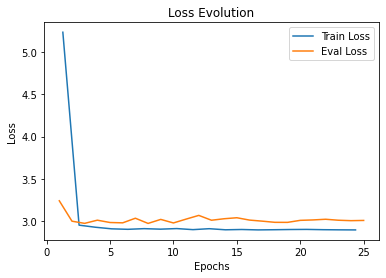

In [ ]:
logs_path = f"logs/{model_name}/logs.npy"
results_1 = load_logs(logs_path)

print_loss_evolution(results_1)

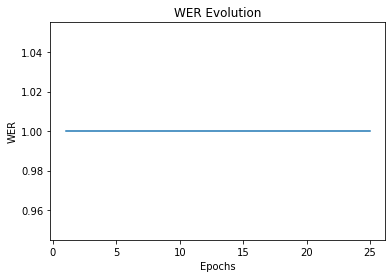

In [ ]:
print_wer_evolution(results_1)

**Comments**:

* WER is one so no improvement through the training
* BUT... We did obtain an improvmeent using more data but we didn't want to use more than hours of data and we wanted to have a similar training than finnish to be able to compare them

### Finnish

#### Load data & Train

In [ ]:
model_name = "wav2vec2-base-finnish25"

In [ ]:
wer_metric = evaluate.load("wer")

training_args = TrainingArguments(
    output_dir="output",
    group_by_length=True,
    per_device_train_batch_size=8,
    evaluation_strategy="epoch",
    num_train_epochs=25, #25 ?
    fp16=True,    # For GPU
    gradient_checkpointing=True,
    save_strategy = 'epoch',
    save_steps=50,
    eval_steps=50,
    logging_steps=50,
    learning_rate=1e-4, #3e-4
    weight_decay=0.005, #
    warmup_steps=100,
    save_total_limit=2,
    load_best_model_at_end=True,
)

In [ ]:
#run this to download one dataset and prepare dataset and model

langage = "finnish"
download_dataset(datasets_list[langage])
dataset_path = join(root, "datasets", datasets_list[langage], code_datasets[langage])
df = prepare_dataframe(dataset_path, time = 40*2)

chars_to_ignore_regex = '[\,\?\.\!\-\;\:\_"<>()«»]'

css, processor = create_processor(df, chars_to_ignore_regex)

css = css.map(prepare_dataset, remove_columns=css.column_names["train"], num_proc=4)

model, trainer = prepare_trainer(css, processor, training_args)

In [ ]:
read_vocabulary(f"logs/{model_name}")

'  :  23
*  :  20
[PAD]  :  27
[UNK]  :  26
a  :  24
d  :  9
e  :  14
g  :  1
h  :  6
i  :  15
j  :  16
k  :  5
l  :  8
m  :  21
n  :  2
o  :  17
p  :  4
q  :  22
r  :  11
s  :  12
t  :  10
u  :  13
v  :  3
x  :  7
y  :  18
|  :  19
ä  :  0
ö  :  25


In [ ]:
if retraining:
  trainer.train()

  model.push_to_hub(f"{model_name}")
  processor.push_to_hub(f"{model_name}")
  save_logs(trainer, "/content/drive/MyDrive/M2/SLP/logs", f"{model_name}")

if not retraining:
  model = AutoModelForCTC.from_pretrained(f"salmaouardi120/{model_name}")
  processor = Wav2Vec2Processor.from_pretrained(f"salmaouardi120/{model_name}")
  model.to("cuda")

Downloading:   0%|          | 0.00/2.34k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/378M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/257 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/278 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/311 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/96.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


### Results

In [ ]:
%%capture
css = DatasetDict({"test": Dataset.from_pandas(df[df.split == 1])})
css = css.map(remove_special_characters)
css = css.map(prepare_dataset, remove_columns=css.column_names["test"], num_proc=4)
wer_metric = evaluate.load("wer")

In [ ]:
results = css["test"].map(map_to_result, remove_columns=css["test"].column_names)

wer_test_2 = wer_metric.compute(predictions=results["pred_str"], references=results["text"])

print("Test WER: {:.3f}".format(wer_test_2))

  0%|          | 0/314 [00:00<?, ?ex/s]

Test WER: 0.451


In [ ]:
show_random_elements(results)

,pred_str,text
0,levolle hankiutua nuttuun sakukin naulasta otti heitti sen hartti oilleen ja siirtyi mikä aittaan,levolle hankkiutua nuttunsa kukin naulasta otti heitti sen hartioilleen ja siirtyi mikä aittaan
1,joka tämäkin kopistettuaan kahavit piipustaan alkoi haukotellen hakeat nuttuaan naulasta,joka tämäkin kopistettuaan kahvit piipustaan alkoi haukotellen hakea nuttuaan naulasta
2,paha hän et tehkä sittenkin olisi periynyt jos lamppolisi särkynyt mutta eisi let toki tullut mitään mede uunillä sentollo,paha hänet ehkä sittenkin olisi perinyt jos lamppu olisi särkynyt mutta ei sille toki tullut mitään mene uunille sen tollo
3,etteikö hän maata men on aika j olisi käsissä jos mieli huomena kirkkoon nosta,etteiköhän maatamenon aika jo olisi käsissä jos mieli huomenna kirkkoon nousta
4,e jakuun sitten puhaisee nii se sammuvaisammu mutta en minä sitänytymmära vaikka kuinka selitteliset,ja kun sitten puhaisee niin se sammuu vai sammuumutta en minä sitä nyt ymmärrä vaikka kuinka selittelisit
5,ellei karsinä puolelta tupaa olisi alka nut kuulua hiljaista vikinää ja ripinää,ellei karsinapuolelta tupaa olisi alkanut kuulua hiljaista vikinää ja ripinää
6,mutta kun hän noin kiireesti sivulle sirtyinniin pelästyivät vakot hevosetkin hänen valkeita housuan karsivat nekin vään syrjaän ja,mutta kun hän noin kiireesti sivulle siirtyi niin pelästyivät vauhkot hevosetkin hänen valkeita housujaan kaarsivat nekin vähän syrjään ja
7,sillä en tuota ole ennenkään tehnyt ja ovat hän nuoa tyttäreni muutkin miehelle pääseet yhtä hyvinkuin rikkaanpienkin lapset,sillä en tuota ole ennenkään tehnyt ja ovathan nuo tyttäreni muutkin miehelle päässeet yhtä hyvin kuin rikkaampienkin lapset
8,ja sen hän heti kohta pani työstään pois jonka tiesi yjalassa kulkeneen lopulta ei tupaan jaänyt muita kuin aapoja tuomas,ja sen hän heti kohta pani työstään pois jonka tiesi yöjalassa kulkeneen lopulta ei tupaan jäänyt muita kuin aapo ja tuomas
9,ellei aapo olisi nopeasti hypännyt ojaan josta lika hänen ympärilleen roiskahti olisi hänesä siinä paikssa tullut multaisen maantien miejaä,ellei aapo olisi nopeasti hypännyt ojaan josta lika hänen ympärilleen roiskahti olisi hänestä siinä paikassa tullut multaisen maantien miehiä


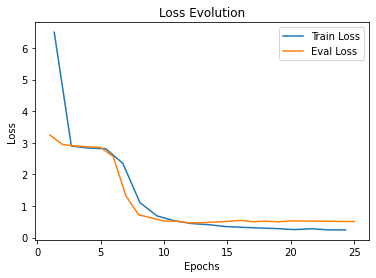

In [ ]:
logs_path = f"logs/{model_name}/logs.npy"
results_2 = load_logs(logs_path)

print_loss_evolution(results_2)

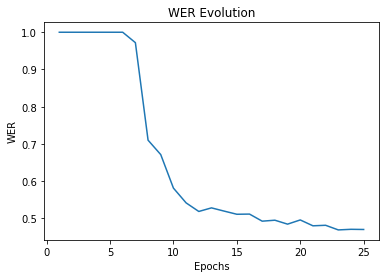

In [ ]:
print_wer_evolution(results_2)

### Comparison

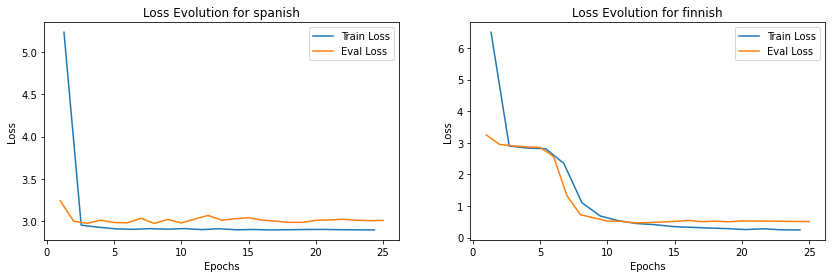

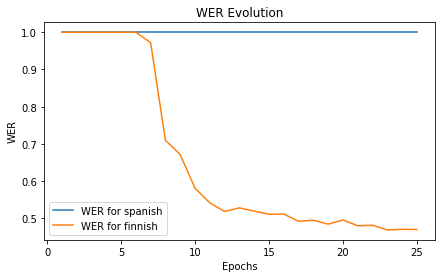

In [ ]:
compare_loss_evolution({"spanish" : results_1, "finnish" : results_2})
compare_wer_evolution({"spanish" : results_1, "finnish" : results_2})

## Finetune Multilingual Wav2Vec

In addition to using the base Wav2Vec we also tried to use a Mulitlingual pretrained Wav2Vec called XLSR-53. 

This model is designed to learn speech representations that are useful across multiple languages. It is trained over 53 languages.

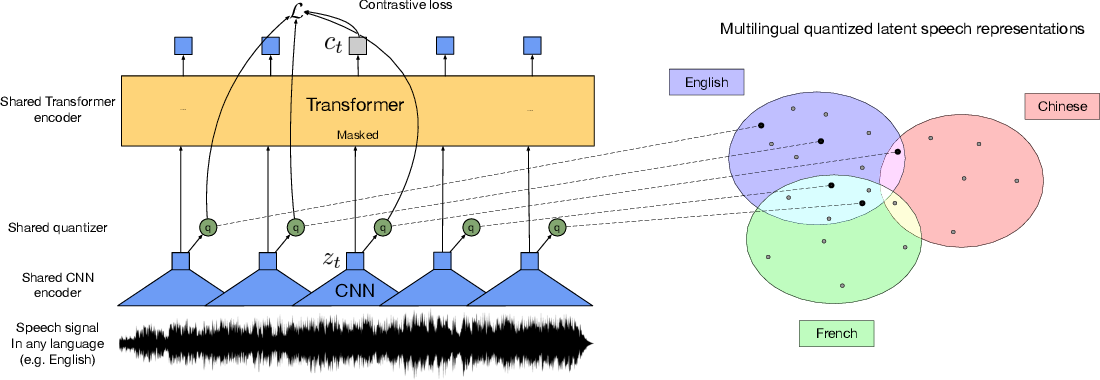

**Comments**: For both Languages learning rate is very important. With 3e-4 we converge really well, with 1e-4 we do not !

### Spanish

#### Load data & Train

In [ ]:
model_name = "wav2vec2-multi-spanish_lr3_25_40"

In [ ]:
wer_metric = evaluate.load("wer")

training_args = TrainingArguments(
    output_dir="output",
    group_by_length=True,
    per_device_train_batch_size=8,
    evaluation_strategy="epoch",
    num_train_epochs=25, #25 ?
    fp16=True,    # For GPU
    gradient_checkpointing=True,
    save_strategy = 'epoch',
    save_steps=50,
    eval_steps=50,
    logging_steps=50,
    learning_rate=3e-4, #1e-4
    #weight_decay=0.005, #
    warmup_steps=100,
    save_total_limit=2,
    load_best_model_at_end= True,
)

In [ ]:
#run this to download one dataset and prepare dataset and model

langage = "spanish"
download_dataset(datasets_list[langage])
dataset_path = join(root, "datasets", datasets_list[langage], code_datasets[langage])

df = prepare_dataframe(dataset_path, time = 40*2)

chars_to_ignore_regex = '[\,\?\.\!\-\;\:\_"<>()«»]'
css, processor = create_processor(df, chars_to_ignore_regex, return_attention_mask = True)

css = css.map(prepare_dataset, remove_columns=css.column_names["train"], num_proc=4)

model, trainer = prepare_trainer(css, processor, training_args, model_pretrained = "facebook/wav2vec2-large-xlsr-53")

In [ ]:
if retraining:
  trainer.train()

  model.push_to_hub(f"{model_name}")
  processor.push_to_hub(f"{model_name}")
  save_logs(trainer, "/content/drive/MyDrive/M2/SLP/logs", f"{model_name}")

In [ ]:
%%capture
if not retraining:
  model = AutoModelForCTC.from_pretrained(f"RomainMsrd/{model_name}")
  model.to("cuda")
  processor = Wav2Vec2Processor.from_pretrained(f"RomainMsrd/{model_name}")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


#### Results

In [ ]:
%%capture
css = DatasetDict({"test": Dataset.from_pandas(df[df.split == 1])})
css = css.map(remove_special_characters)
css = css.map(prepare_dataset, remove_columns=css.column_names["test"], num_proc=4)
wer_metric = evaluate.load("wer")

In [ ]:
results = css["test"].map(map_to_result, remove_columns=css["test"].column_names)

wer_test_3 = wer_metric.compute(predictions=results["pred_str"], references=results["text"])

print("Test WER: {:.3f}".format(wer_test_3))

  0%|          | 0/320 [00:00<?, ?ex/s]

Test WER: 0.165


In [ ]:
show_random_elements(results)

,pred_str,text
0,durante nuestra conversación advertí que la multituda humentaba apretándose más,durante nuestra conversación advertí que la multitud aumentaba apretándose más
1,ni con la espantosa centuplicación de pequeñas fuerzas que sin matar imposibilitaban la defensa,ni con la espantosa centuplicación de pequeñas fuerzas que sin matar imposibilitaban la defensa
2,descosío coje ese fusil con más garvo tienes en la man un cirio de procesión,descosío coge ese fusil con más garbo ¿tienes en la mano un cirio de procesión
3,salió al mostrador de la taberna rompiéndo tres vasos y dos botellas que sin duda le cargarían en cuenta al eredero de la corona de dos mundos,salió al mostrador de la taberna rompiendo tres vasos y dos botellas que sin duda le cargarían en cuenta al heredero de la corona de dos mundos
4,juimos a palacio continuó santurrias que no pudiendo sostenerse la había cado al suelo,juimos a palacio continuó santurrias que no pudiendo sostenerse ya había caído al suelo
5,con las paredes con la luna con la parra que enredandose en los maderos del corredor ejztendía sus flacos y secos brazos para cojer alguna cosa,¿con las paredes con la luna con la parra que enredándose en los maderos del corredor extendía sus flacos y secos brazos para coger alguna cosa
6,mientras limpiaba el sudor de su frente coronada con los laurel les oratorios la moza de la taberna se acercaba escanciarle vino,mientras limpia el sudor de su frente coronada con los laureles oratorios la moza de la taberna se acerca a escanciarle vino
7,componían la personas de anmbos sesos y de todas las clases de la sociedad,componíanla personas de ambos sexos y de todas las clases de la sociedad
8,óltima gradación de turbante oriental otros muchos calzados con la silenciosa alpargata en ese pie de gato que tambien cuadra al ladrón,última gradación de turbante oriental otros muchos calzados con la silenciosa alpargata ese pie de gato que tan bien cuadra al ladrón
9,pero mi turbación y estupor eran tan grandes ante aquella escena que ni aun hacertaba hacerme cargo de lo que tenía entre las manos,pero mi turbación y estupor eran tan grandes ante aquella escena que ni aun acertaba a hacerme cargo de lo que tenía entre las manos


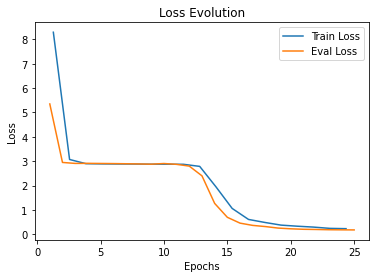

In [ ]:
logs_path = f"logs/{model_name}/logs.npy"
results_3 = load_logs(logs_path)

print_loss_evolution(results_3)

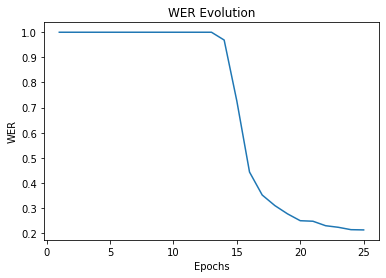

In [ ]:
print_wer_evolution(results_3)

### Validation Set

### Finnish

#### Load data & Train

In [ ]:
model_name = "wav2vec2-multi-finnish_lr3_25_40"

In [ ]:
wer_metric = evaluate.load("wer")

training_args = TrainingArguments(
    output_dir="output",
    group_by_length=True,
    per_device_train_batch_size=8,
    evaluation_strategy="epoch",
    num_train_epochs=25, #25 ?
    fp16=True,    # For GPU
    gradient_checkpointing=True,
    save_strategy = 'epoch',
    save_steps=50,
    eval_steps=50,
    logging_steps=50,
    learning_rate=3e-4, #3e-4
    #weight_decay=0.005, #
    warmup_steps=100,
    save_total_limit=2,
    load_best_model_at_end= True,
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [ ]:
#run this to download one dataset and prepare dataset and model

langage = "finnish"
download_dataset(datasets_list[langage])
dataset_path = join(root, "datasets", datasets_list[langage], code_datasets[langage])

df = prepare_dataframe(dataset_path, time = 5) #40*2)

chars_to_ignore_regex = '[\,\?\.\!\-\;\:\_"<>()«»]'
css, processor = create_processor(df, chars_to_ignore_regex, return_attention_mask = True)

css = css.map(prepare_dataset, remove_columns=css.column_names["train"], num_proc=4)

model, trainer = prepare_trainer(css, processor, training_args, model_pretrained = "facebook/wav2vec2-large-xlsr-53")

Load data...
Total duration :  10h 32min 3s
Load audio...

Number of line : 20 

In [ ]:
if retraining:
  trainer.train()

  model.push_to_hub(f"{model_name}")
  processor.push_to_hub(f"{model_name}")
  save_logs(trainer, "/content/drive/MyDrive/M2/SLP/logs", f"{model_name}")

In [ ]:
%%capture
if not retraining:
  model = AutoModelForCTC.from_pretrained(f"RomainMsrd/{model_name}")
  model.to('cuda')
  processor = Wav2Vec2Processor.from_pretrained(f"RomainMsrd/{model_name}")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


#### Results

In [ ]:
langage = "finnish"
dataset_path = join(root, "datasets", datasets_list[langage], code_datasets[langage])
df = prepare_dataframe(dataset_path, time = 40*2)

Load data...
Total duration :  10h 32min 3s
Load audio...

Number of line : 600 

In [ ]:
%%capture
css = DatasetDict({"test": Dataset.from_pandas(df[df.split == 1])})
css = css.map(remove_special_characters)
css = css.map(prepare_dataset, remove_columns=css.column_names["test"], num_proc=4)
wer_metric = evaluate.load("wer")

In [ ]:
results = css["test"].map(map_to_result, remove_columns=css["test"].column_names)

wer_test_4 = wer_metric.compute(predictions=results["pred_str"], references=results["text"])

print("Test WER: {:.3f}".format(wer_test_4))

  0%|          | 0/314 [00:00<?, ?ex/s]

Test WER: 0.376


In [ ]:
show_random_elements(results)

In [ ]:
logs_path = f"logs/{model_name}/logs.npy"

In [ ]:
results_4 = load_logs(logs_path)

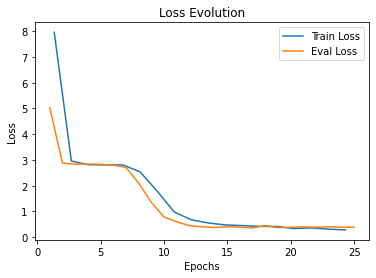

In [ ]:
print_loss_evolution(results_4)

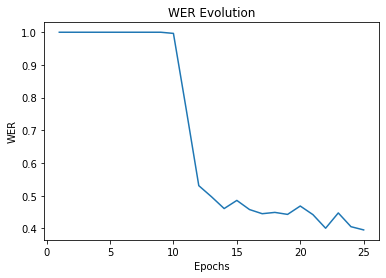

In [ ]:
print_wer_evolution(results_4)

### Comparison

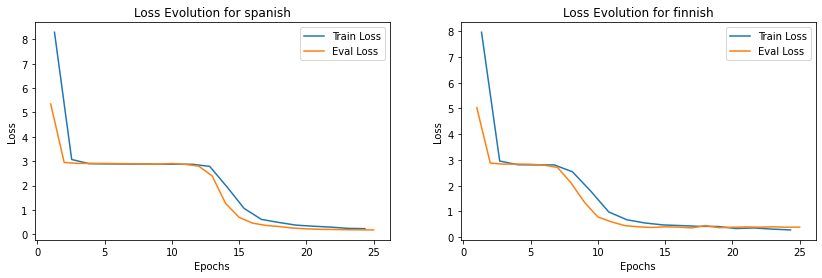

In [ ]:
compare_loss_evolution({"spanish" : results_3, "finnish" : results_4})

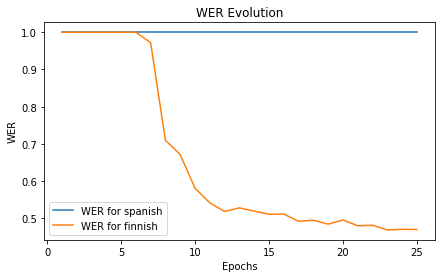

In [ ]:
compare_wer_evolution({"spanish" : results_1, "finnish" : results_2})

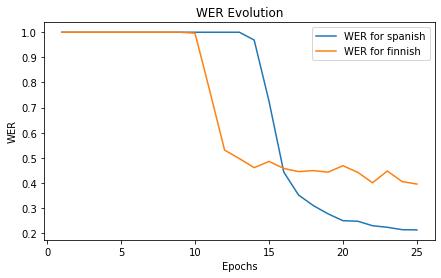

In [ ]:
compare_wer_evolution({"spanish" : results_3, "finnish" : results_4})

# Conclusion

In [ ]:
test_wer_base = [1, wer_test_2]
test_wer_multi = [wer_test_3, wer_test_4]
label = ['Spanish_Base', 'Finnish_Base', 'Spanish_Multilingual', 'Finnish_Multilingual', ]
test_wer_base, test_wer_multi

([1, 0.4505520319473808], [0.16481749477407942, 0.3758515386422363])

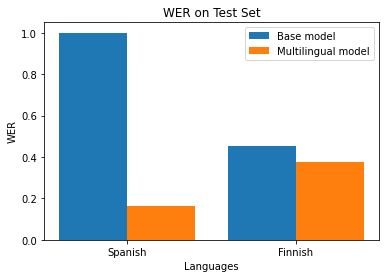

In [ ]:
X = ['Spanish','Finnish']
test_wer_base = [1, wer_test_2]
test_wer_multi = [wer_test_3, wer_test_4]
  
X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, test_wer_base, 0.4, label = 'Base model')
plt.bar(X_axis + 0.2, test_wer_multi, 0.4, label = 'Multilingual model')
  
plt.xticks(X_axis, X)
plt.xlabel("Languages")
plt.ylabel("WER")
plt.title("WER on Test Set")
plt.legend()
plt.show()

**Conclusion :** 

* Multilingual pretrained Wav2Vec show better result for low resource languages !  

* BUT ... we did not test our model on a new dataset with different speaker

**What we learned:**

* Wav2Vec is verry sensitive to hyperparameters
